In [451]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import KFold, StratifiedKFold,RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import ElasticNet, LogisticRegression, SGDClassifier
from sklearn.svm import SVC
import sklearn.gaussian_process.kernels as kernels
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

In [491]:
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")
sample_submission = pd.read_csv("./sample_submission.csv")

train.drop(['id'],1,inplace=True)
test.drop(['id'],1,inplace=True)

In [6]:
train.head()

,gravity,ph,osmo,cond,urea,calc,target
0,1.0130,6.1900,443,14.8000,124,1.4500,0
1,1.0250,5.4000,703,23.6000,394,4.1800,0
2,1.0090,6.1300,371,24.5000,159,9.0400,0
3,1.0210,4.9100,442,20.8000,398,6.6300,1
4,1.0210,5.5300,874,17.8000,385,2.2100,1


In [3]:
train.describe()

,gravity,ph,osmo,cond,urea,calc,target
count,414.0000,414.0000,414.0000,414.0000,414.0000,414.0000,414.0000
mean,1.0179,5.9555,651.5459,21.4379,278.6570,4.1146,0.4444
std,0.0067,0.6423,234.6766,7.5147,136.4422,3.2176,0.4975
min,1.0050,4.7600,187.0000,5.1000,10.0000,0.1700,0.0000
25%,1.0120,5.5300,455.2500,15.5000,170.0000,1.4500,0.0000
50%,1.0180,5.7400,679.5000,22.2000,277.0000,3.1300,0.0000
75%,1.0220,6.2800,840.0000,27.6000,385.0000,6.6300,1.0000
max,1.0400,7.9400,1236.0000,38.0000,620.0000,14.3400,1.0000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  414 non-null    float64
 1   ph       414 non-null    float64
 2   osmo     414 non-null    int64  
 3   cond     414 non-null    float64
 4   urea     414 non-null    int64  
 5   calc     414 non-null    float64
 6   target   414 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 22.8 KB


In [5]:
train.shape

(414, 7)

In [6]:
train.isna().sum()

gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64

In [7]:
train[train.duplicated()]

,gravity,ph,osmo,cond,urea,calc,target


# Visualization

In [8]:
float_cols = train.select_dtypes(include='float64').columns.tolist()
int_cols = train.select_dtypes(include='int64').columns.tolist()
bool_cols = train.select_dtypes(include='bool').columns.tolist()

In [37]:
4 % 3

1

CPU times: user 855 ms, sys: 1.81 s, total: 2.67 s
Wall time: 607 ms


<Figure size 800x550 with 0 Axes>

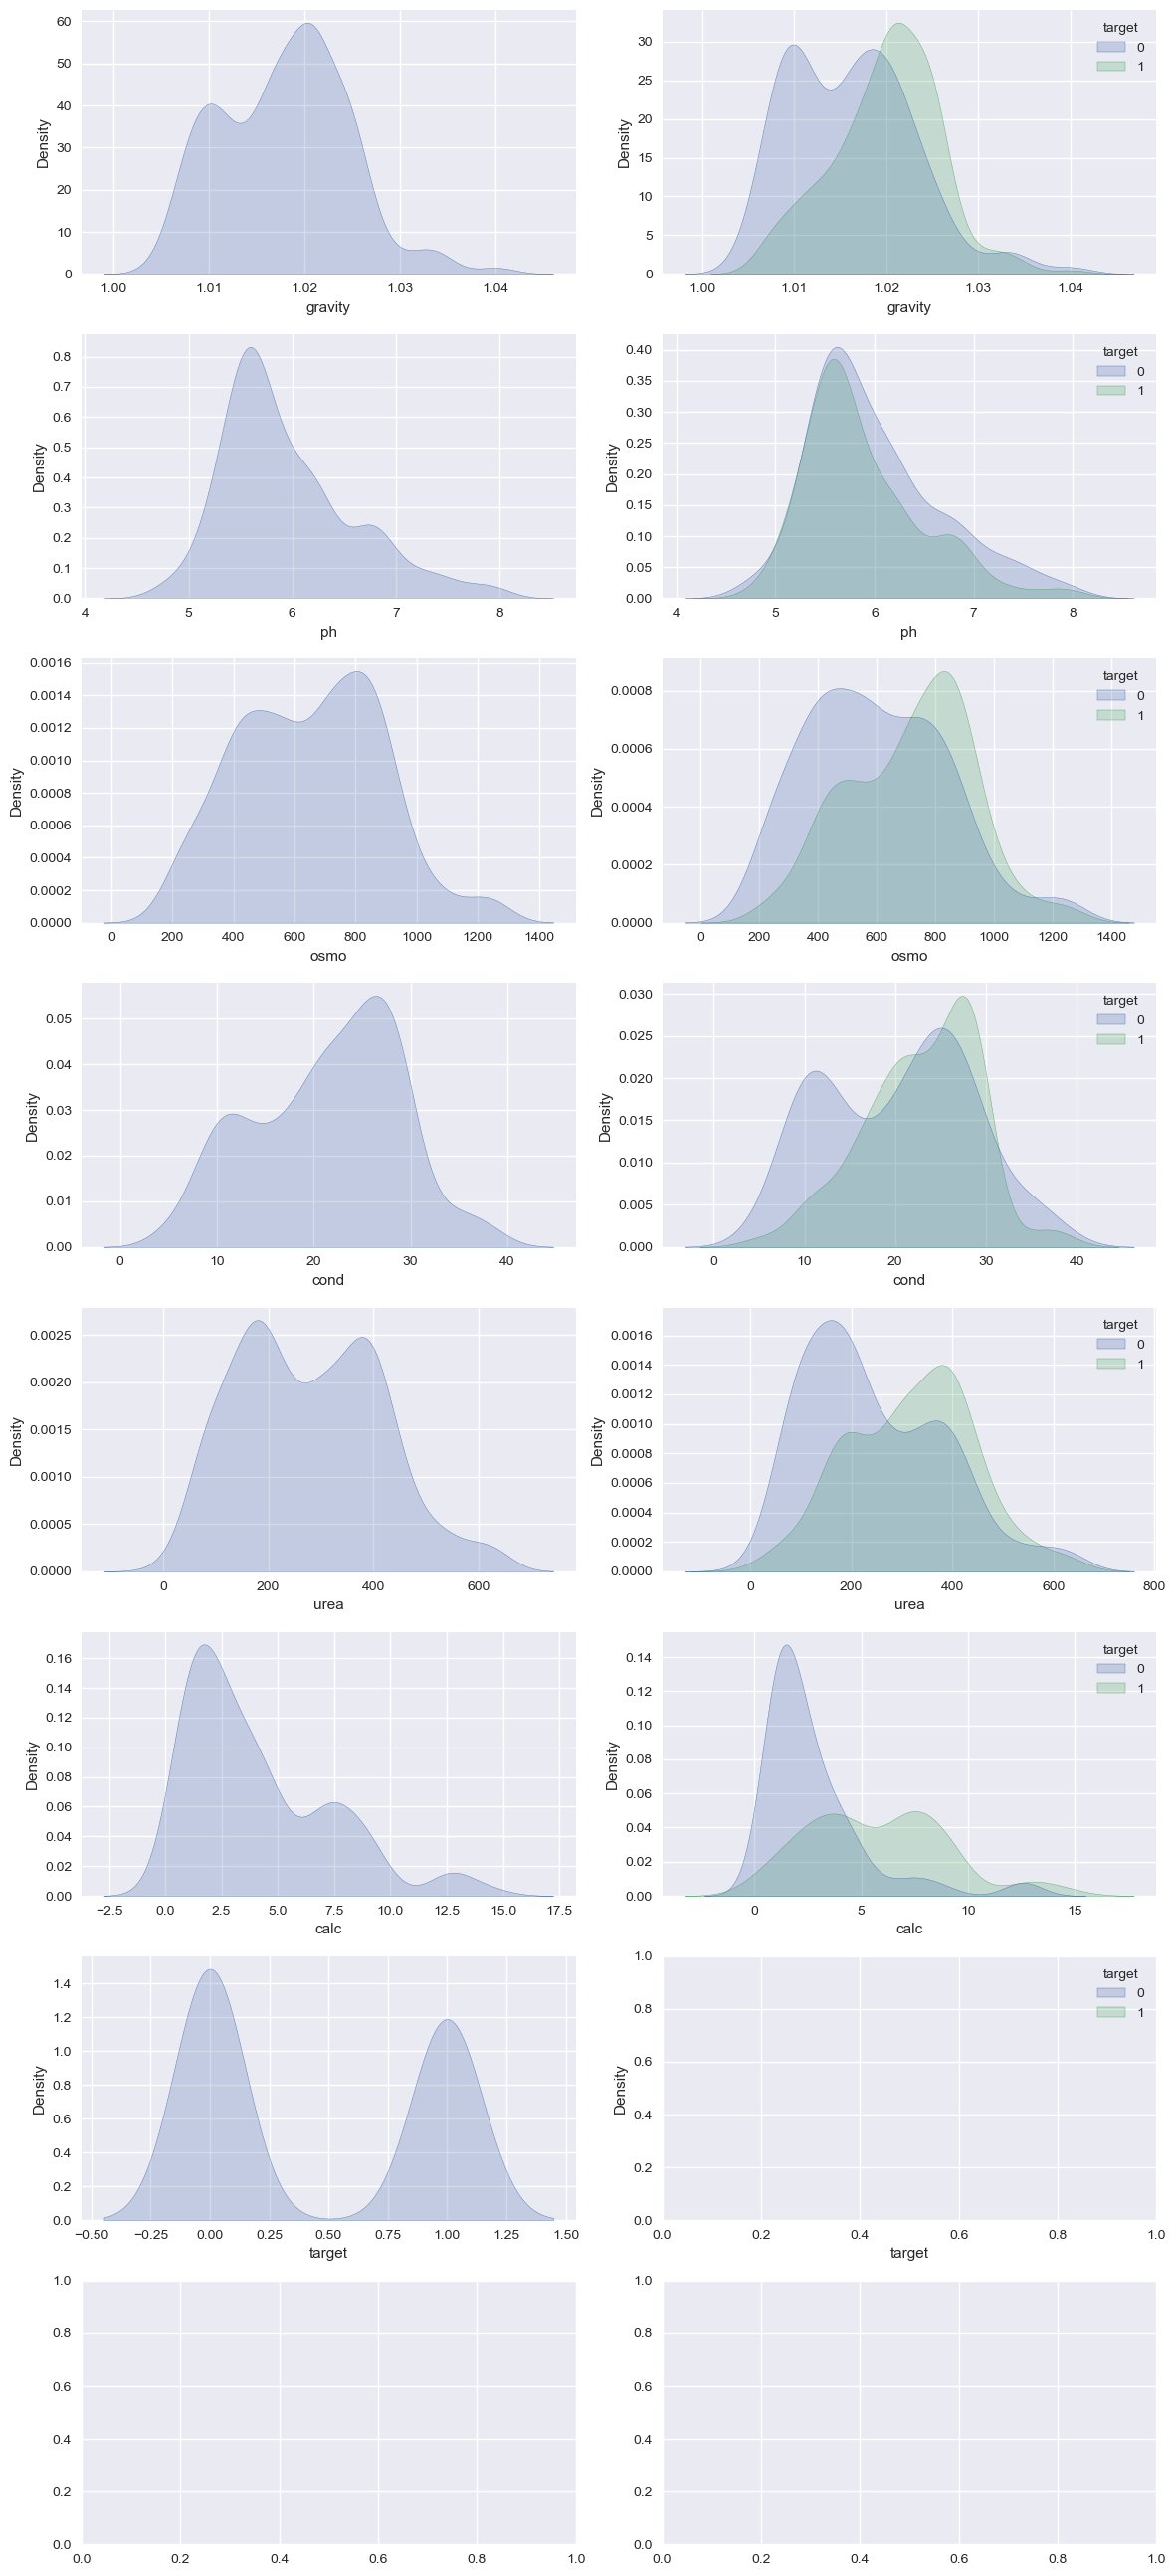

In [43]:
%%time
i = 0

plt.figure()
plt.subplots(8,2, figsize=(12,26))
for col in train.columns:
    i+=1
    plt.subplot(8,2,i)
    sns.kdeplot(train[col], shade=True)
    i+=1
    plt.subplot(8,2,i)
    sns.kdeplot(train[col], shade=True, hue=train['target'])
    
plt.tight_layout()

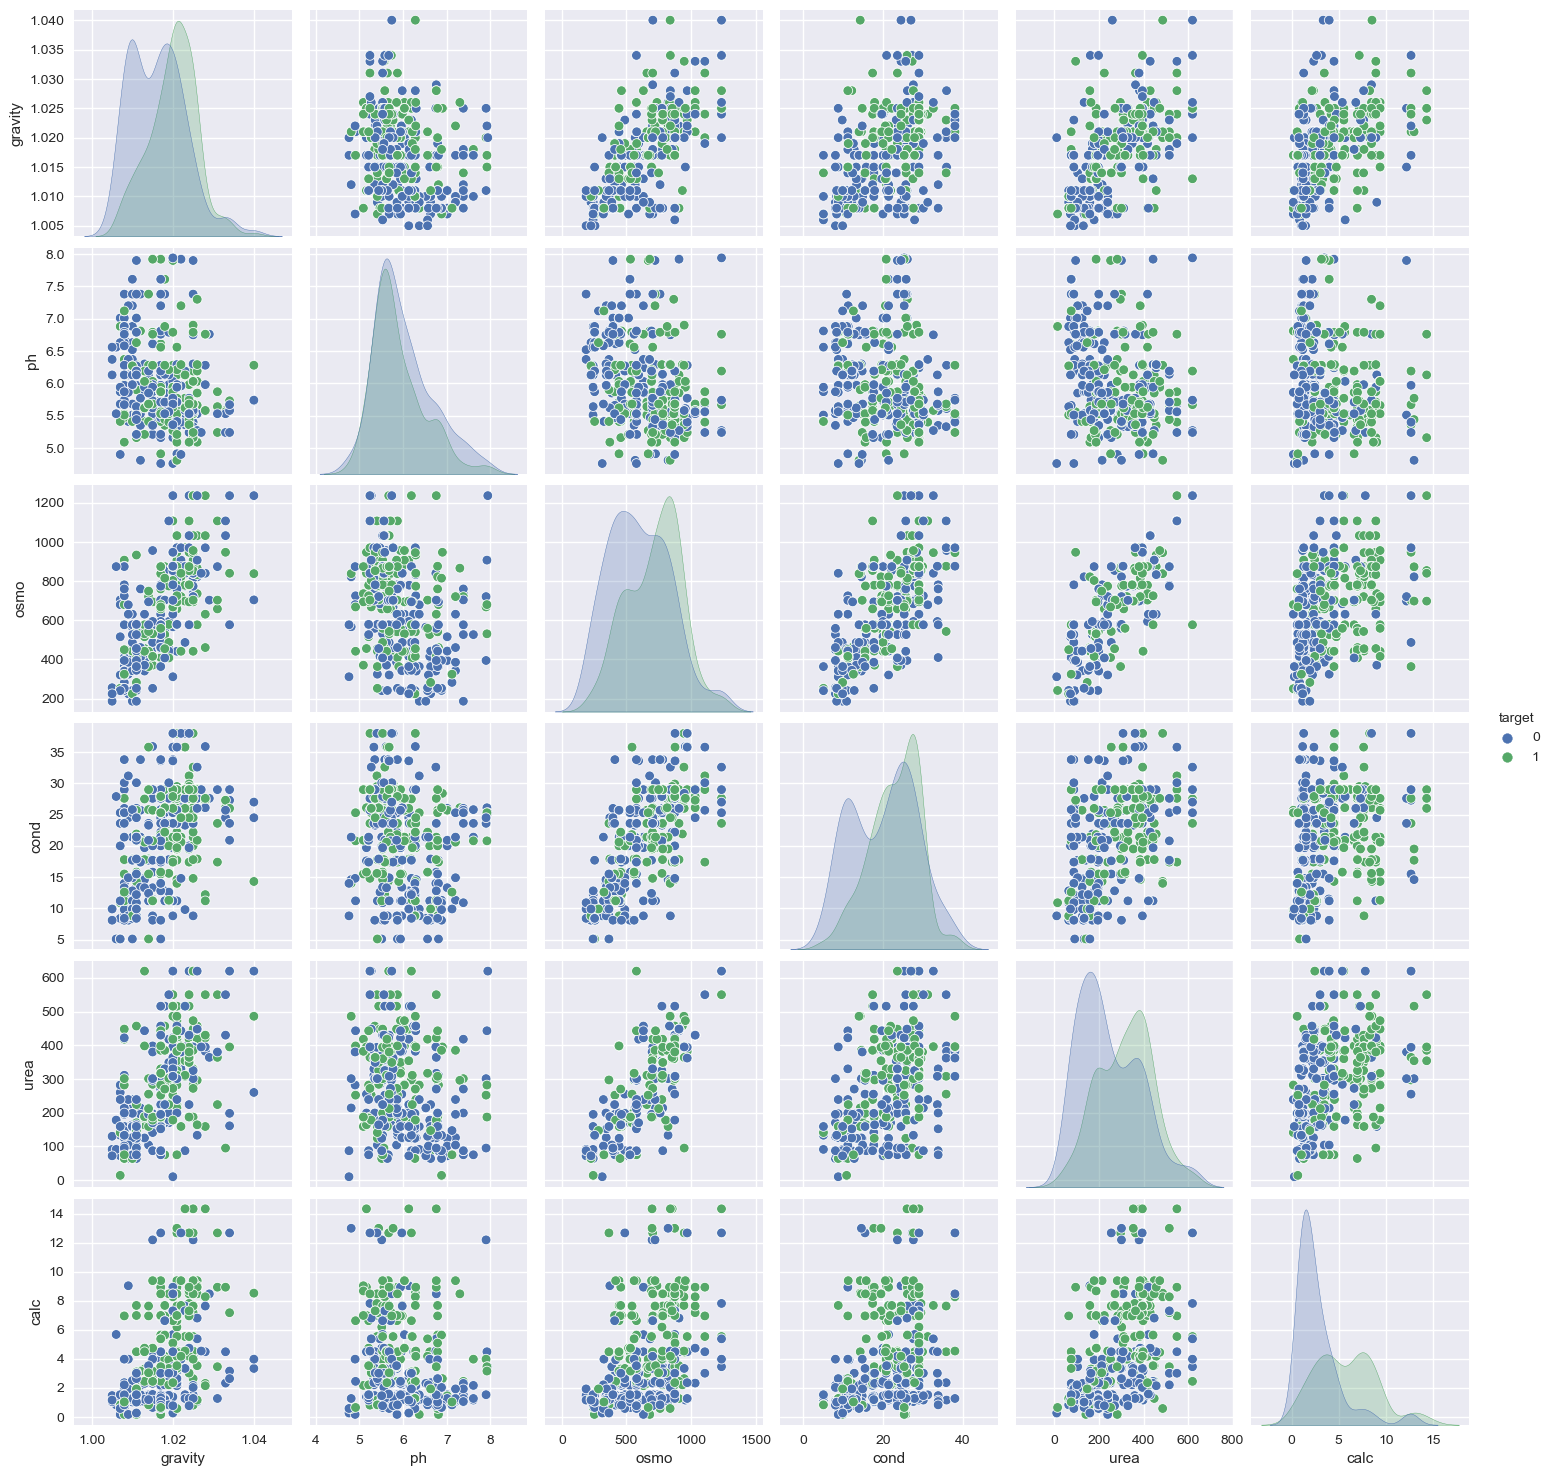

In [24]:
sns.pairplot(train, hue='target')

<AxesSubplot:>

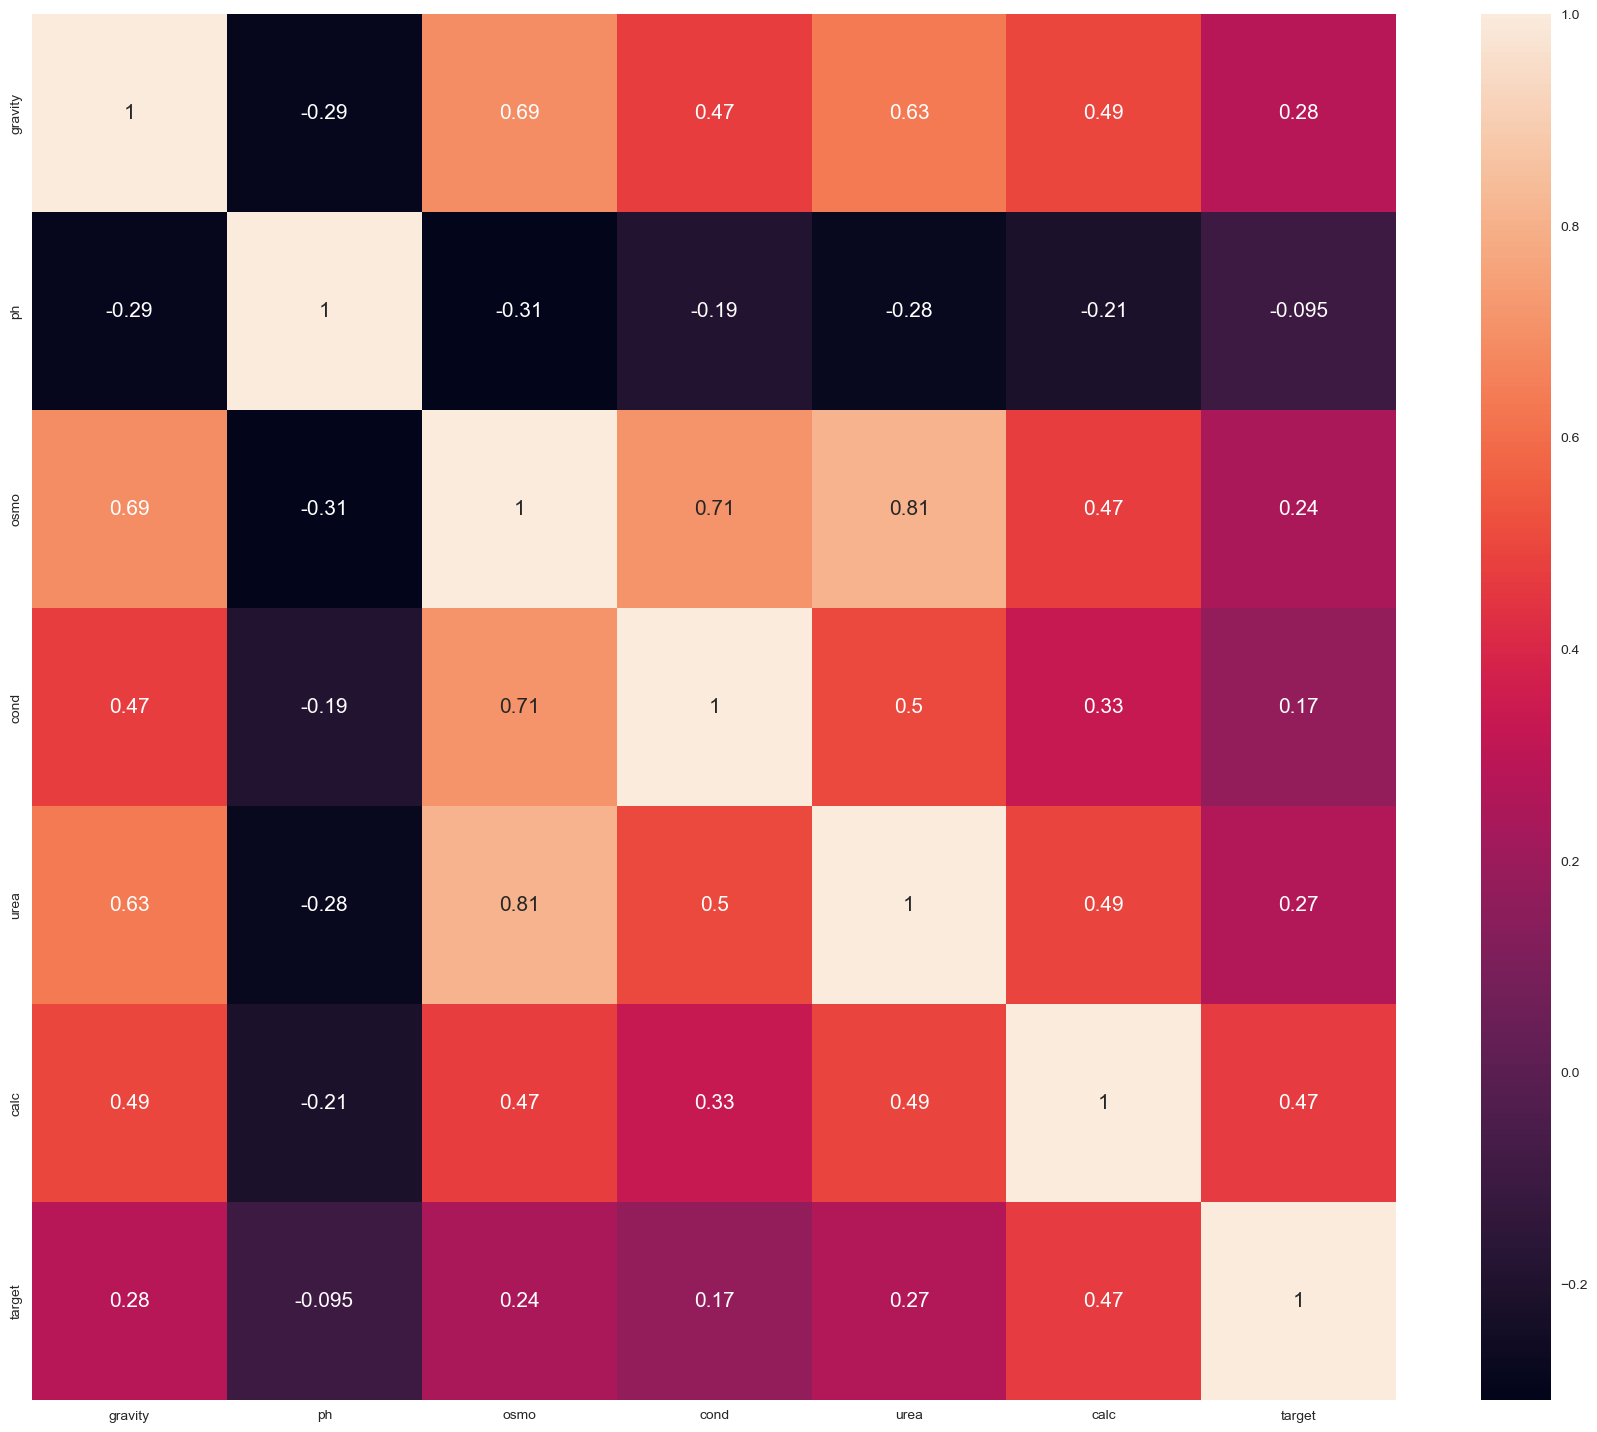

In [25]:
plt.figure(figsize=(22,18))
sns.heatmap(train.corr(),annot=True, annot_kws={'fontsize':15},)

# Feature Engineering

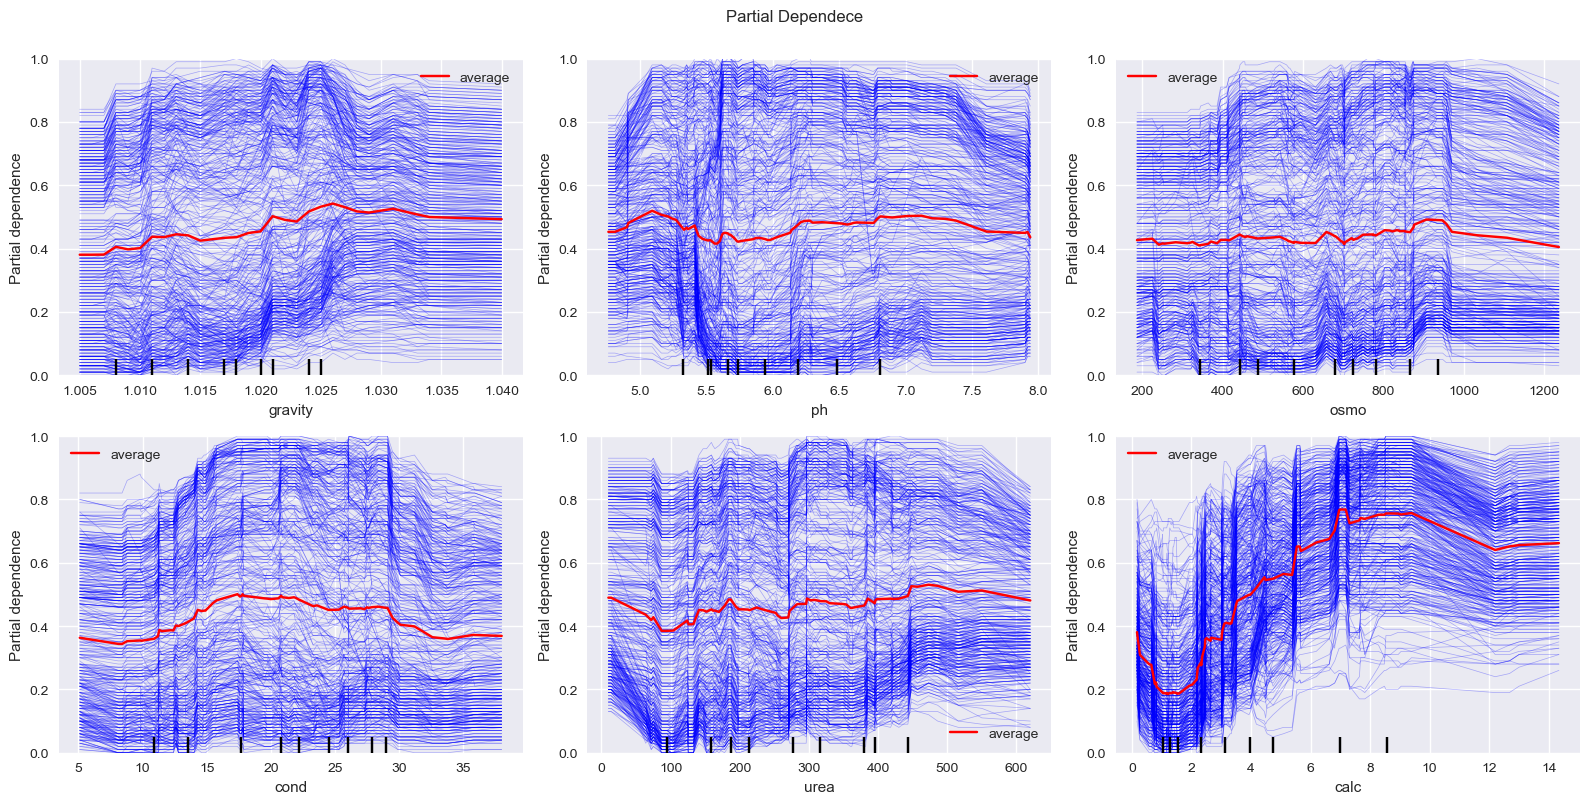

In [232]:
#Partial

feat=['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
#PartialDenpendencyDisplay
model = RandomForestClassifier(random_state=1)
model.fit(train[feat], train[target])

features_for_pdp = feat
f, ax = plt.subplots(2,3, figsize=(16,8))
plt.suptitle("Partial Dependece", y=1)

PartialDependenceDisplay.from_estimator(model, train[feat],
                                       features_for_pdp, 
                                        pd_line_kw={'color': 'red'},
                                       ice_lines_kw={'color':'blue'},
                                       kind='both',
                                       ax=ax.ravel()[:len(features_for_pdp)])

plt.tight_layout()

In [483]:
# features update

train['gravity'] = train['gravity'].clip(None, 1.03)
train['calc'] = train['calc'].clip(None, 8)

In [492]:
from feature_engine.creation import MathFeatures,RelativeFeatures

fea = RelativeFeatures(variables=test.columns.tolist(), reference=test.columns.tolist(), func=['mul','div'])

train1=fea.fit_transform(train)
corr = train1.corr()
corr['target'][abs(corr['target']) > 0.3].sort_values(ascending=False)
# plt.figure(figsize=(24,18))
# sns.heatmap(fea.fit_transform(train).corr(), annot=True)

target             1.0000
calc_div_gravity   0.4677
calc               0.4674
calc_mul_gravity   0.4671
gravity_mul_calc   0.4671
calc_mul_ph        0.4651
ph_mul_calc        0.4651
calc_div_ph        0.4572
cond_mul_calc      0.4230
calc_mul_cond      0.4230
osmo_mul_calc      0.4099
calc_mul_osmo      0.4099
calc_div_osmo      0.3985
urea_mul_calc      0.3914
calc_mul_urea      0.3914
calc_div_cond      0.3868
calc_mul_calc      0.3766
calc_div_urea      0.3227
Name: target, dtype: float64

In [484]:
#feature engineering
def feature_engineering(df):
    df['calc_div_gravity'] = df['calc'] / df['gravity']
    df['calc_mul_gravity'] = df['calc'] * df['gravity']
    df['calc_mul_ph'] = df['calc'] * df['ph']
    df['calc_div_ph'] = df['calc'] / df['ph']
    df['cond_mul_calc'] = df['cond'] * df['calc']
    df['osmo_mul_calc'] = df['osmo'] * df['calc']
    df['calc_div_osmo'] = df['calc'] / df['osmo']
    df['urea_mul_calc'] = df['urea'] * df['calc']
    df['calc_div_cond'] = df['calc'] / df['cond']
    df['calc_mul_calc'] = df['calc'] * df['calc']
    df['calc_div_urea'] = df['calc'] / df['urea']
    return df

train = feature_engineering(train)
test = feature_engineering(test)

# Model

In [493]:
%%time
target = 'target'
# original_features = test.columns
original_features = ['gravity', 'calc']

result_list = []
def score_model(model, features_used, label=None):
    score_list = []
    oof = np.zeros_like(train[target])
    kf = RepeatedStratifiedKFold(random_state=42)
    for fold, (idx_tr, idx_val) in enumerate(kf.split(train[original_features], train[target])):
        X_train = train.iloc[idx_tr][features_used]
        X_valid = train.iloc[idx_val][features_used]
        y_train = train.iloc[idx_tr][target]
        y_valid = train.iloc[idx_val][target]
        
        model.fit(X_train, y_train)
        tscore = roc_auc_score(y_train, model.predict(X_train))
        y_valid_pred = model.predict(X_valid)
        score = roc_auc_score(y_valid, y_valid_pred)
        if type(model) == Pipeline and type(model.steps[-1][1]) == GaussianProcessClassifier:
            print("Kernel: ", model.steps[-1][1].kernel_)
        print(f" Fold {fold} : tscore = {tscore:.3f} score = {score:.3f}")
        oof[idx_val] = y_valid_pred
        score_list.append(score)
        
    score = sum(score_list) / len(score_list)
    print(f" Avg. roc score : {score:.3f}")
    if label is not None:
        global result_list
        result_list.append((label, score, oof))

CPU times: user 32 µs, sys: 3 µs, total: 35 µs
Wall time: 52.9 µs


# ensemble

In [525]:
%%time
ensemble_model = VotingClassifier(
    [('rf', make_pipeline(ColumnTransformer([('pt', 'passthrough', original_features)]),
                          RandomForestClassifier(n_estimators=100,random_state=42))),
     ('svc', make_pipeline(ColumnTransformer([('pt', 'passthrough', original_features)]),
                             StandardScaler(),
                             SVC(random_state=42,probability=True))),
     ('CB',make_pipeline(ColumnTransformer([('pt','passthrough', original_features)]),
                          CatBoostClassifier(silent=True,random_state=42))),
     ('LGBM',make_pipeline(ColumnTransformer([('pt','passthrough', original_features)]),
                          LGBMClassifier(n_estimators=100, random_state=42))),
     ('GAUSSIAN',make_pipeline(ColumnTransformer([('pt','passthrough', original_features)]),
                              GaussianProcessClassifier(random_state=42)))
    ],voting='soft')

score_model(model=ensemble_model,
            features_used=['gravity','calc'],
            label='RF_SVC_CB_LGBM_GAUSSIAN')

 Fold 0 : tscore = 0.842 score = 0.686
 Fold 1 : tscore = 0.808 score = 0.756
 Fold 2 : tscore = 0.836 score = 0.743
 Fold 3 : tscore = 0.829 score = 0.781
 Fold 4 : tscore = 0.828 score = 0.774
 Fold 5 : tscore = 0.846 score = 0.702
 Fold 6 : tscore = 0.812 score = 0.778
 Fold 7 : tscore = 0.838 score = 0.707
 Fold 8 : tscore = 0.845 score = 0.729
 Fold 9 : tscore = 0.813 score = 0.697
 Fold 10 : tscore = 0.833 score = 0.678
 Fold 11 : tscore = 0.847 score = 0.667
 Fold 12 : tscore = 0.803 score = 0.805
 Fold 13 : tscore = 0.831 score = 0.756
 Fold 14 : tscore = 0.820 score = 0.810
 Fold 15 : tscore = 0.834 score = 0.729
 Fold 16 : tscore = 0.845 score = 0.662
 Fold 17 : tscore = 0.816 score = 0.791
 Fold 18 : tscore = 0.823 score = 0.754
 Fold 19 : tscore = 0.829 score = 0.833
 Fold 20 : tscore = 0.836 score = 0.637
 Fold 21 : tscore = 0.799 score = 0.759
 Fold 22 : tscore = 0.845 score = 0.689
 Fold 23 : tscore = 0.847 score = 0.688
 Fold 24 : tscore = 0.836 score = 0.706
 Fold 25 :

In [523]:
pred = ensemble_model.predict_proba(test[['gravity','calc']])[:,1]

In [524]:
sample_submission['target'] = pred
sample_submission.to_csv("./gravity_calc_rf_svc_cat_lgbm_gaussian.csv",index=False)

# model Compare

- ensemble baseline :0.732 : 0.85
- ensemble baseline + Features (corr > 0.3) : 0.725 -> LB 0.862
- ensemble baseline + Features (corr > 0.25) : 0.726 -> LB 0.84
- ensemble baseline + Features (corr > 0.3868) : 0.735 -> LB : 0.853
- ensemble ERF + SVC + CAT + Features (corr > 0.3) : 0.727 -> LB : 0.84
---
피쳐는 상관관계가 0.3이상이고, RF + SVC + CAT으로 한다.
- gravity, calc clip : 0.733 -> LB : bad scores
- **gravity, calc rf_svc_cat_lgbm_gaussian : 0.738 -> LB : 0.868**
- gravity, calc clip rf_svc_cat_lgbm_gaussian : 0.744 -> LB : 0.864
- . svc_cat_lgbm_gaussian -> LB : 0.866
- . rf_csvc_cat_lgbm_gaussian weights [0.1, 0.2,0.3,0.1,0.3] : 0.740-> LB : 0.863